In [28]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import time
import torch

from gglm.glm.holi import MMDGLM
from kernel.rect import KernelRect
from sptr.sptr import SpikeTrain

In [29]:
class GLM(torch.nn.Module):
    
    def __init__(self, b, eta):
        super(GLM, self).__init__()
#         self.b = b
        self.eta = eta
        
        self.register_parameter("b", torch.nn.Parameter(b))
        
        eta_coefs = torch.from_numpy(eta.coefs).float()
        self.register_parameter("eta_coefs", torch.nn.Parameter(eta_coefs))
        
    def run(self, dt, T, shape=(1,), full=False):
        
        shape = (T, ) + shape
        
#         u = torch.zeros(shape, requires_grad=True)# * np.nan
#         r = np.zeros(shape) * np.nan
#         eta_conv = torch.zeros(shape, requires_grad=True) * self.eta_coefs[0]
        eta_conv = torch.zeros(shape, requires_grad=False)
#         _eta_conv = torch.zeros(shape, requires_grad=True) * self.eta_coefs[0]
#         mask_spikes = torch.zeros(shape, requires_grad=True)
        mask_spikes = []
        
        eta_basis = torch.from_numpy(eta.interpolate_basis(np.arange(0, eta.support[1], 1))).float()
        eta_vals = torch.matmul(eta_basis, self.eta_coefs)
        T_eta = eta_vals.shape[0]

        for t in range(T):

#             u[t, ...] = b + eta_conv[t, ...]
            u = self.b + eta_conv[t, ...]
            r = torch.exp(u)
            p_spk = 1 - torch.exp(-r * dt)
            
            rand = torch.rand(*shape[1:])
            _mask_spikes = spike_fn(p_spk - rand)
            mask_spikes.append(_mask_spikes)
            
#             eta_conv[t + 1:min(T, t + 1 + T_eta), :] += _mask_spikes.detach()[None, :] * eta_vals[:min(T_eta, T - t - 1), None]
            
            if self.eta is not None and t < T - 1:
# #                 eta_conv[t + 1:min(T, t + 1 + T_eta), mask_spikes[t, ...].detach() > 0] += eta_vals[:min(T_eta, T - t - 1), None]
                eta_conv[t + 1:min(T, t + 1 + T_eta), _mask_spikes.detach() > 0] += eta_vals[:min(T_eta, T - t - 1), None]
#                 eta_conv[t + 1:min(T, t + 1 + T_eta), _mask_spikes.detach() > 0] += _mask_spikes * eta_vals[:min(T_eta, T - t - 1), None]
        
        if full:
            return kappa_conv, eta_conv, u, r, mask_spikes
        else:
            return u, mask_spikes
        
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input / (1.0 + SurrGradSpike.scale*torch.abs(input))**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

# def spike_fn(x):
#     out = torch.zeros_like(x)
#     out[x > 0] = 1.0
#     return out

In [30]:
# f = h5py.File('../cool_stuff/h5test.h5', "r")

# arg_spikes = (torch.tensor(f['MC']['spikeTimes'], dtype=int)[:, 0], torch.tensor(f['MC']['spikeIndices'], dtype=int)[:, 0] - 1)

# dt = 1
# t = torch.arange(0, 1000, dt)
# mask_spikes_train = torch.zeros((len(t), 10), dtype=bool)
# mask_spikes_train[arg_spikes] = True

# n_spk_train = np.sum(mask_spikes_train)
# fr_train = np.mean(np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000)
# nll_pois_proc_train = -bernoulli_log_likelihood_poisson_process(mask_spikes_train)

# st_train = SpikeTrain(t, mask_spikes_train)

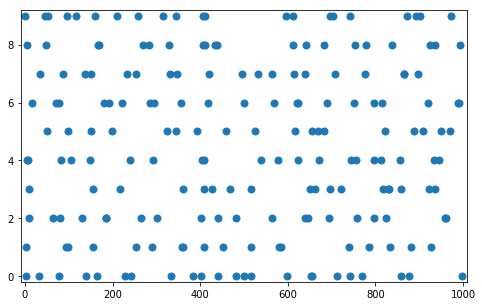

In [40]:
tbins = np.concatenate((np.arange(0, 10, 2), np.arange(10, 100, 10), np.arange(100, 550, 50)))
eta = KernelRect(tbins, -np.exp(-tbins[:-1] / 50))
# eta = KernelRect(tbins, np.zeros(len(tbins) - 1))
b = torch.tensor([-3.])

glm_true = GLM(b, eta)

dt, T = 1, 1000
t = np.arange(0, T, dt)
u, mask_spikes_train = glm_true.run(1, 1000, shape=(10,))
mask_spikes_train = torch.stack(mask_spikes_train)

st_train = SpikeTrain(t, mask_spikes_train.detach().numpy())
st_train.plot()

In [41]:
# t = np.arange(0, 1000, 1)
# np.random.seed(0)
# n = 50
# glm_true = TorchGLM(u0=-4.5, eta=eta_true)
# _, _, mask_spikes = glm_true.sample(t, shape=(n, ))
# st = SpikeTrain(t, mask_spikes)
# n_spk = np.sum(mask_spikes)
# fr = np.mean(np.sum(mask_spikes, 0) / (t[-1] - t[0] + t[1]) * 1000)
# nll_pois_proc_train = -bernoulli_log_likelihood_poisson_process(mask_spikes)
# autocov = np.mean(auto_covariance(mask_spikes, method='fft', subtract_mean=False, 
#                                          stationary_signal=False, biased=False), 1)
# isi = st.isi_distribution()
# mean_isi = np.mean(isi)

# fig, ax = plt.subplots(figsize=(10, 5))
# st.plot(ax=ax)

In [42]:
def phi_fr(t, mask_spikes):
    T = t[-1] - t[0] + t[1]
    return torch.sum(mask_spikes, 0).double()[None, :] * 1000 / T

def ker_fr(t, mask_spikes1, mask_spikes2):
    T = t[-1] - t[0] + t[1]
    fr1 = torch.sum(mask_spikes1, 0).double() * 1000 / T
    fr2 = torch.sum(mask_spikes2, 0).double() * 1000 / T
    return fr1[:, None] * fr2[None, :]

def ker_sch_heavi(t, mask_spikes1, mask_spikes2):
    T = t[-1] - t[0] + t[1]
    cum1 = torch.cumsum(mask_spikes1, dim=0)
    cum2 = torch.cumsum(mask_spikes2, dim=0)
    gramian = torch.exp(-torch.sum((cum1[:, :, None] - cum2[:, None, :])**2, dim=0) / sd2)
    return gramian

In [46]:
# mask_spikes_train.dtype

In [48]:
# phi, kernel, lam_mmd, biased, lr, clip = phi_fr, None, 1e-2, False, 1e-2, 1e0
# phi, kernel, lam_mmd, biased, lr, clip = None, ker_fr, 1e1, True, 5e-3, 1e0
# phi, kernel, lam_mmd, biased, lr, clip, sd2 = None, ker_sch_heavi, 1e1, False, 1e-2, 1e0, 1e4

# phi, kernel, lam_mmd, biased, lr, clip, sd2 = None, ker_sch_heavi, 1e1, False, 1e-2, 1e0, 5e3 # 1st

phi, kernel, lam_mmd, biased, lr, clip, sd2 = None, ker_sch_heavi, 1e1, False, 2e-2, 1e0, 5e3 # bueno 

beta0, beta1 = 0, 0
n_batch_fr = 200
num_epochs = 300
n_metrics = 1

time0 = time.time()

u00 = (glm_true.b.detach().clone() * 1.2).numpy()
eta0 = glm_true.eta.copy()
eta0.coefs = eta0.coefs * 1.2

mmdglm = MMDGLM(u0=u00, eta=eta0)
optim = torch.optim.Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1))

loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, mask_spikes_train.detach(), phi=phi, kernel=kernel, 
                                                log_likelihood=False, 
                                              n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, optim=optim, clip=clip, 
                                                num_epochs=num_epochs, 
                                              verbose=True, metrics=None, n_metrics=n_metrics)
loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
nll_normed_mmd = (metrics_mmd['nll'] - nll_pois_proc_train) / np.log(2) / n_spk
metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
iterations_mmd = np.arange(1, num_epochs + 1, 1)

_, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st.t, shape=(st.mask.shape[1],))
st_fr_mmd = SpikeTrain(st.t, mask_spikes_fr_mmd)

# _, r_dc_mmd = mmdglm.sample_conditioned(st_train.t, st_train.mask)
# isi_fr_mmd = st_fr_mmd.isi_distribution()
# mean_isi_fr_mmd = np.mean(isi_fr_mmd)
# r_dc_mmd, r_fr_mmd = r_dc_mmd * 1000, r_fr_mmd * 1000

# _, r_fr_mmd_long, mask_spikes_fr_mmd_long = mmdglm.sample(t_long, shape=(st_train.mask.shape[1],))
# st_fr_mmd_long = SpikeTrain(t_long, mask_spikes_fr_mmd_long)
# isi_fr_mmd_long = st_fr_mmd_long.isi_distribution()
# mean_isi_fr_mmd_long = np.mean(isi_fr_mmd_long)
# r_fr_mmd_long = r_fr_mmd_long * 1000
# autocov_mmd_long = np.mean(auto_covariance(mask_spikes_fr_mmd_long, method='fft', 
#                                            subtract_mean=False, stationary_signal=False, biased=False), 1)

# time1 = time.time()
# print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')

 epoch 57 of 300 loss 40.6443892172

KeyboardInterrupt: 

In [5]:
def loss(mask_spikes, mask_spikes_train):
    n_spikes = torch.sum(mask_spikes) / mask_spikes.shape[1]
    n_spikes_train = torch.sum(mask_spikes_train) / mask_spikes_train.shape[1]
    return (n_spikes - n_spikes_train)**2

tbins = np.concatenate((np.arange(0, 10, 2), np.arange(10, 100, 10), np.arange(100, 1000, 50)))
# eta = KernelRect(tbins, -np.exp(-tbins[:-1] / 50))
eta = KernelRect(tbins, np.zeros(len(tbins) - 1))
b = torch.tensor([-4.2])
glm = GLM(b, eta)
optimizer = torch.optim.Adam(glm.parameters(), lr=2e-2, betas=(0.9,0.999))

dt, T = 1, 1000
t = np.arange(0, T, dt)

loss_hist = []
for e in range(100):
    u, mask_spikes = glm.run(dt, T, shape=(25,))
    mask_spikes = torch.stack(mask_spikes)
#     m,_=torch.max(output,1)
#     log_p_y = log_softmax_fn(m)
    loss_val = loss(mask_spikes, mask_spikes_train)

    optimizer.zero_grad()
    loss_val.backward()
#     print(glm.b.grad, glm.eta_coefs.grad, glm.b.detach())
    optimizer.step()
    loss_hist.append(loss_val.item())

/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


In [16]:
print(glm.b, glm.eta_coefs)

Parameter containing:
tensor([-4.1901], requires_grad=True) Parameter containing:
tensor([0.0042, 0.0045, 0.0042, 0.0041, 0.0036, 0.0047, 0.0043, 0.0047, 0.0047,
        0.0045, 0.0044, 0.0044, 0.0045, 0.0042, 0.0050, 0.0055, 0.0059, 0.0057,
        0.0054, 0.0058, 0.0060, 0.0061, 0.0058, 0.0058, 0.0057, 0.0058, 0.0058,
        0.0059, 0.0056, 0.0050, 0.0011], requires_grad=True)


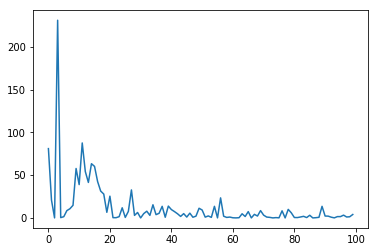

In [9]:
plt.plot(loss_hist)

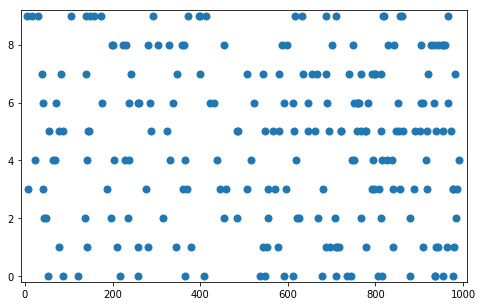

In [11]:
dt, T = 1, 1000
t = np.arange(0, T, dt)
u, mask_spikes = glm.run(1, 1000, shape=(10,))
# basis = torch.from_numpy(eta.interpolate_basis(np.arange(0, eta.support[1], 1))).float()
mask_spikes = torch.stack(mask_spikes)

# optimizer = torch.optim.SGD(glm.parameters(), lr=2e-1)
# optimizer = torch.optim.SGD([glm.b], lr=2e-1)
# loss_val = torch.sum(mask_spikes)

# optimizer.zero_grad()
# print(glm.b.grad, glm.eta_coefs.grad)
# loss_val.backward()
# print(glm.b.grad, glm.eta_coefs.grad, glm.b)
# optimizer.step()
# print(glm.b.grad, glm.eta_coefs.grad, glm.b)
# loss_hist.append(loss_val.item())

st = SpikeTrain(t, mask_spikes.detach().numpy())
st.plot()

In [12]:
torch.sum(mask_spikes) / mask_spikes.shape[1]

tensor(22.7000, grad_fn=<DivBackward0>)

In [29]:
mask_spikes.grad_fn

In [93]:
[i for i in glm.parameters()]

[Parameter containing:
 tensor([-4.2000], requires_grad=True), Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.], requires_grad=True)]